In [25]:
from SimPEG import *
from SimPEG import Maps
from SimPEG import EM
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP.TDEM import geteref, Problem3DIP_Linear, SurveyLinear
from simpegEMIP.TDEM import Survey, Rx
from simpegEMIP.TDEM import Problem3DEM_e, Problem3D_e
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
import discretize
eps = np.finfo(float).eps

Simulatin and deep sea hydrothermal deposits explortaion using WISTEM (K. Nakayama and A. Saito, 2016) (K.Nakayama M. Motoori and A. Saito,2019).
This simulates the impact of pressure vessel in 2D cyrindrical simpegEMIP(S. Kang et al, 2015). SimPEG(R. Cockett et al, 2015), simpegEM(L. Heagy et al,2017). 
On-Time: 200msec
ramp time: 200usec
Transmitter Loop: 3.5m Square Loop
Receiver Loop: Coincident-type
Number of Turn: 5
3.5m rectangular loop has equivalent area for 2.0m circular. 
Pressure vessel 
Conductivity: 1e6
height: 0.20
Width: 0.20
Thickness: 0.04

In [26]:
base_freq=1.25
on_time=0.2
rmp_time=200e-6
rec_time=0.2
smp_freq=50e3
time_step=1./smp_freq

In [27]:
tx_radius = (3.5)/(np.sqrt(np.pi))
tx_circumference = 2*np.pi*tx_radius
tx_area = np.pi*tx_radius**2
n_turns = 5
print(f"radius of transmitter: {tx_radius}")

radius of transmitter: 1.9746635424171473


In [28]:
con_air = 1e-8
con_sea = 3.0
con_seabed = 1.0
con_vessel = 1e6
thick_target = 30.
con_target = 1/0.15
chg_target = 0.3
chg_sea , chg_base, chg_ref = 0.,0.,0.
t_target = 1.0e-3
t_sea, t_base, t_ref = 1.0e-3, 1.0e-3, 1.0e-3
c_target = 0.8
c_sea, c_base, c_ref = 0.6,0.6,0.6
frame_z = 0.2
height_vessel = 0.20
width_vessel = 0.20
thick_vessel = 0.04
tx_current = 1

In [29]:
csx1, csz1 = tx_radius/200., tx_radius/200.
ncsx1, ncsz1 = 50, 50 
padx1max, padz1max = 1.3, 1.3
csx2, csz2 = tx_radius/4.,tx_radius/4.
x2max, z2max =  50., 50
x2lim, z2lim = 2000, 2000
padx2max, padz2max = 1.3, 1.3



In [30]:
csx1, csz1 = tx_radius/200., tx_radius/200.
ncsx1, ncsz1 = 50, 50 

# csx1, csz1 = tx_radius/20., tx_radius/20.
# ncsx1, ncsz1 = 5, 5 
padx1max, padz1max = 1.3, 1.3
csx2, csz2 = tx_radius/4.,tx_radius/4.
x2max, z2max =  50., 50
x2lim, z2lim = 2000, 2000
padx2max, padz2max = 1.3, 1.3



In [31]:
hx = np.load("16_hx.npy")
hz = np.load("16_hz.npy")


In [32]:
# hx = mesh_Pressure_Vessel(tx_radius, csx1, ncsx1, padx1max, csx2, x2max, x2lim, padx2max)
# hzneg = mesh_Pressure_Vessel(tx_radius, csz1, 1, padz1max, csz2, z2max, z2lim, padz2max)
# hzpos = mesh_Pressure_Vessel(tx_radius, csz1, ncsz1, padz1max, csz2, z2max, z2lim, padz2max)
# hz = np.r_[hzneg[::-1], hzpos]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    

In [33]:
tx_height = tx_radius/4.0
print(tx_height)
radius_vessel = csx1*50.
thickness_vessel = csz1*5.
print(f"Vessel radius: {radius_vessel:.3f}, thickness: {thickness_vessel:.3f}")

0.4936658856042868
Vessel radius: 0.494, thickness: 0.049


In [34]:
def plot_vessel_outline(ax=None, lw=0.3):
    x_plot_out = width_vessel*np.r_[-1,1,1,-1,-1]
    y_plot_out = height_vessel*np.r_[1,1,0,0,1]  +frame_z 
    x_plot_in = (width_vessel-thick_vessel)*np.r_[-1,1,1,-1,-1]
    y_plot_in = (height_vessel-2*thick_vessel)*np.r_[1,1,0,0,1] + thick_vessel +frame_z 
    if ax is not None:
        ax.plot(x_plot_out, y_plot_out, 'k-', lw=lw)
        ax.plot(x_plot_in, y_plot_in, 'k-', lw=lw)
        return ax
    else :
        plt.plot(x_plot_out, y_plot_out, 'k-', lw=lw)
        plt.plot(x_plot_in, y_plot_in, 'k-', lw=lw)


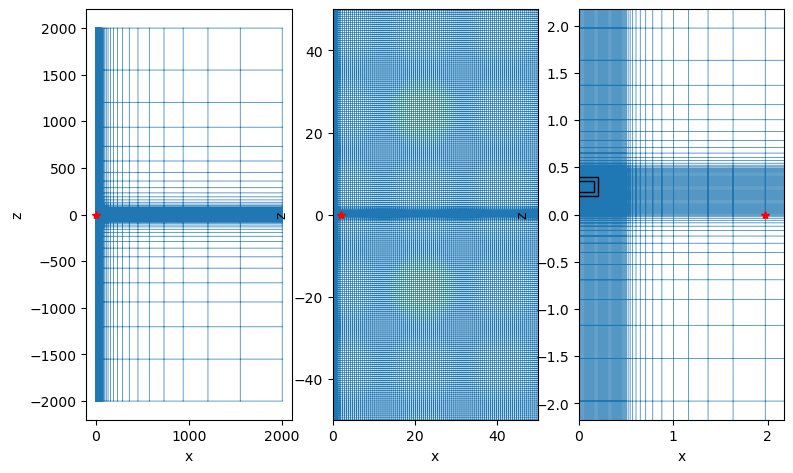

In [35]:
fig, ax = plt.subplots(1,3, figsize=(9,7))
ax[0] = mesh.plotGrid(ax=ax[0], show_it=False, linewidth=0.5)  
ax[1] =  mesh.plotGrid(ax=ax[1], show_it=False, linewidth=0.5)
ax[1].set_xlim(0.,x2max)
ax[1].set_ylim(-z2max , x2max )
ax[2] =  mesh.plotGrid(ax=ax[2], show_it=False, linewidth=0.5)
ax[2].set_xlim(0.,tx_radius*1.1)
ax[2].set_ylim(-tx_radius*1.1,tx_radius*1.1)
ax[2] = plot_vessel_outline(ax[2],lw=1.0)
for a in ax:
    a.set_aspect('equal')
    a.plot(tx_radius,0,'r*')
    a.grid(False)


# Set up mapping

In [36]:

ind_container = (
    (mesh.gridCC[:, 2] <= height_vessel + frame_z) &
    (mesh.gridCC[:, 2] >= frame_z) &
    (mesh.gridCC[:, 0] <= width_vessel)
)

ind_sea = (mesh.gridCC[:, 2] > - tx_height) & ~ind_container
ind_active = ~ind_sea
ind_vessel = (
    (mesh.gridCC[ind_active][:, 2] <= height_vessel + frame_z) &
    (mesh.gridCC[ind_active][:, 2] >= frame_z) &
    (mesh.gridCC[ind_active][:, 0] <= width_vessel)
)
ind_air = (
    (mesh.gridCC[ind_active][:, 2] < height_vessel - thick_vessel + frame_z) &
    (mesh.gridCC[ind_active][:, 2] > thick_vessel + frame_z) &
    (mesh.gridCC[ind_active][:, 0] < width_vessel - thick_vessel)
)

ind_metal = ind_vessel &  ~ind_air
ind_layer = ((mesh.gridCC[ind_active][:, 2] <= - tx_height) & 
             (mesh.gridCC[ind_active][:, 2] > -( tx_height + thick_target)) )
ind_seabed =  mesh.gridCC[ind_active][:, 2] <= -( tx_height + thick_target)


In [37]:
print(mesh.nC)
print(ind_active.sum())
print(ind_vessel.sum())
print(ind_air.sum())
print(ind_metal.sum())
print(ind_layer.sum())
print(ind_seabed.sum())
assert ind_active.sum() == ind_air.sum() + ind_metal.sum() + ind_layer.sum() + ind_seabed.sum()


61664
24672
420
192
228
11844
12408


In [38]:
indices_list = [ind_metal, ind_air, ind_layer, ind_seabed]
active_map_sigma = Maps.InjectActiveCells(mesh= mesh,
             indActive=ind_active  , valInactive=np.log(con_sea))
projection_map_sigma = Maps.SurjectUnits(indices_list)
## Kill indices for the seawater

## Exponential map to convert the model to conductivity
exp_map_sigma = Maps.ExpMap(mesh)
sigmaInfMap = exp_map_sigma*active_map_sigma *  projection_map_sigma

sigma_target = np.log(np.r_[
    con_sea, con_sea, con_target/(1-chg_target), con_seabed]
    )
sigma_target_vessel = np.log(np.r_[
    con_vessel, con_air, con_target/(1-chg_target), con_seabed]
    )

In [39]:
sigmaInf = sigmaInfMap*sigma_target_vessel
print(sigmaInf.max())

999999.9999999995


In [40]:
## Kill indices for the seawater
active_map_eta = Maps.InjectActiveCells(mesh= mesh,
             indActive=ind_active  , valInactive=chg_sea)
projection_map_eta = Maps.SurjectUnits(indices_list)
## map to convert the model to cahrgeabillity
etaMap = active_map_eta *  projection_map_eta
eta_target = np.r_[
    chg_sea, chg_sea, chg_target, chg_base]


In [41]:
etaMap*eta_target

array([0., 0., 0., ..., 0., 0., 0.])

In [42]:
## Kill indices for the seawater
active_map_tau = Maps.InjectActiveCells(mesh= mesh,
             indActive=ind_active  , valInactive=np.log(t_sea))
projection_map_tau = Maps.SurjectUnits(indices_list)
## map to convert the model to time constant
exp_map_tau = Maps.ExpMap(mesh)
tauMap = exp_map_tau*active_map_tau *  projection_map_tau
tau_target = np.log(np.r_[
    t_sea, t_sea, t_target, t_base])


In [43]:
tauMap*tau_target

array([0.001, 0.001, 0.001, ..., 0.001, 0.001, 0.001])

In [44]:
## Kill indices for the seawater
active_map_expc = Maps.InjectActiveCells(mesh= mesh,
             indActive=ind_active  , valInactive=c_sea)
## map to convert the model to exponent C
projection_map_expc = Maps.SurjectUnits(indices_list)
cMap = active_map_expc *  projection_map_expc
expc_target = np.r_[
    c_sea, c_sea, c_target, c_base]


In [45]:
cMap*expc_target

array([0.6, 0.6, 0.6, ..., 0.6, 0.6, 0.6])

In [46]:
# model_target = np.log(np.r_[
#     sigma_sea, sigma_sea, sigma_target, sigma_seabed]
#     )
# model_vessel = np.log(np.r_[
#     sigma_vessel, sigma_air, sigma_sea, sigma_sea]
#     )
# model_vessel_target = np.log(np.r_[
#     sigma_vessel, sigma_air, sigma_target, sigma_seabed]
#     )



In [47]:
# sigmaInf = np.ones(mesh.nC)*sigma_sea
# inds_layer = np.logical_and(mesh.gridCC[:,2]<-tx_height, mesh.gridCC[:,2]>-tx_height-thick_target)
# sigmaInf[inds_layer] = sigma_target/(1-eta_target)
# print(f"sigma_inf: {sigma_target/(1-eta_target):3e}")
# inds_bed = mesh.gridCC[:,2] <= - tx_height-thick_target
# sigmaInf[inds_bed] = sigma_seabed

In [48]:
# eta = np.zeros(mesh.nC)
# eta[inds_layer] = eta_target
# tau=np.ones(mesh.nC)
# tau[inds_layer] = tau_target
# c=np.ones(mesh.nC)
# c[inds_layer] = c_target

In [49]:
time_steps = [(2e-6,  150),  (5e-6,  150),  (2e-5,  150), (5e-5,  10)]
tstrt, tend = 1e-4, 4.0e-3
steps = np.array([])
for i in range(len(time_steps)):
    dt, n = time_steps[i]
    step_array = dt * np.ones(n)
    steps = np.concatenate((steps, step_array))
time_clc = np.cumsum(steps)
# since using step off waveform
rmp_time = time_clc[0]
time_rec = time_clc[1:] -rmp_time
#time_rec = np.logspace(np.log10(1e-5), np.log10(1e-2), 31)
print(time_rec.shape)

(459,)


In [63]:
#Get EM data
srcloc = np.array([[0., 0., 0.]])

waveform = EM.TDEM.Src.StepOffWaveform()
#waveform = EM.TDEM.Src.RampOffWaveform(offTime = rmp_time)
#waveform = EM.TDEM.Src.VTEMWaveform(offTime=t0, peakTime=tpeak, a=3.)

rxloc = np.array([[tx_radius, 0., 0.]])
rx_e = Rx.Point_e(locs=rxloc, times= time_rec+rmp_time, orientation='y')


src = EM.TDEM.Src.CircularLoop([rx_e],radius=tx_radius, waveform=waveform, loc=srcloc)
survey = Survey([src])
#prb = Problem3DEM_e(mesh, sigma=sigmaInf)
prb_emip = Problem3D_e(mesh,
                      sigmaInf=sigmaInfMap*sigma_target,
                      # sigmaInf=sigmaInfMap*sigma_target_vessel,
                       eta=etaMap*eta_target,
                       tau=tauMap*tau_target,
                       c=cMap*expc_target)
prb_emip.timeSteps =time_steps
prb_emip.Solver = PardisoSolver
prb_emip.pair(survey)



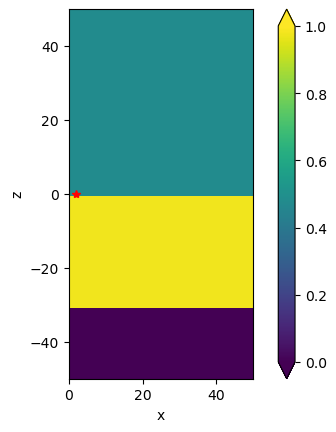

In [64]:
cb= mesh.plotImage(np.log10(sigmaInfMap *sigma_target_vessel))
#cb= mesh.plotImage(etaMap *eta_target)
#cb= mesh.plotImage(np.log10(tauMap*tau_target))
#cb= mesh.plotImage(cMap*expc_target)
plt.colorbar(cb[0], ax=plt.gca(), extend='both')
plt.plot(src.radius,0,'r*')
cb[0].set_clim(0, 1) 
cb[0].set_label('$ \log_{10}SurveyLinear $')
plt.xlim(0., x2max)
plt.ylim(-z2max, z2max )
plt.gca().set_aspect('equal')

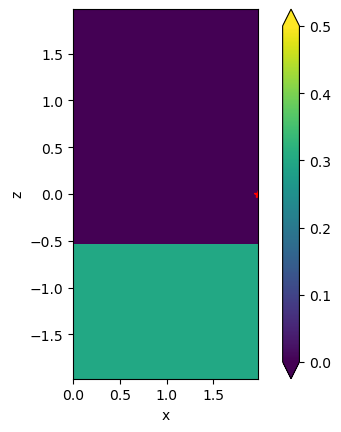

In [52]:
#cb= mesh.plotImage(np.log10(sigmaInfMap *sigma_target))
cb= mesh.plotImage(etaMap *eta_target)
#cb= mesh.plotImage(np.log10(tauMap*tau_target))
#cb= mesh.plotImage(cMap*expc_target)
plt.colorbar(cb[0], ax=plt.gca(), extend='both')
plt.plot(src.radius,0,'r*')
cb[0].set_clim(0,0.5) 
cb[0].set_label('$ \log_{10}SurveyLinear $')
plt.xlim(0., tx_radius)
plt.ylim(-tx_radius, tx_radius)
plt.gca().set_aspect('equal')

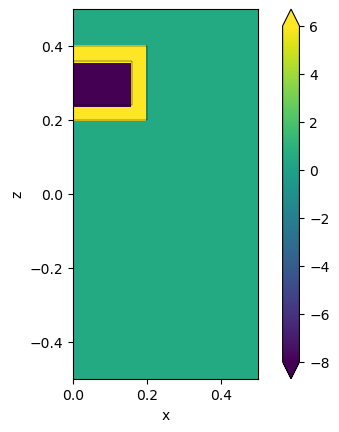

In [65]:
#cb= mesh.plotImage(np.log10(sigmaInfMap *sigma_target))
cb= mesh.plotImage(np.log10(sigmaInfMap *sigma_target_vessel))
#cb= mesh.plotImage(etaMap *eta_target)
#cb= mesh.plotImage(np.log10(tauMap*tau_target))
#cb= mesh.plotImage(cMap*expc_target)
plt.colorbar(cb[0], ax=plt.gca(), extend='both')
plt.plot(src.radius,0,'r*')
cb[0].set_clim(6, -8) 
cb[0].set_label('$ \log_{10}SurveyLinear $')
plot_vessel_outline()
plt.xlim(0.,0.5 )
plt.ylim(-0.5, 0.5 )
plt.gca().set_aspect('equal')

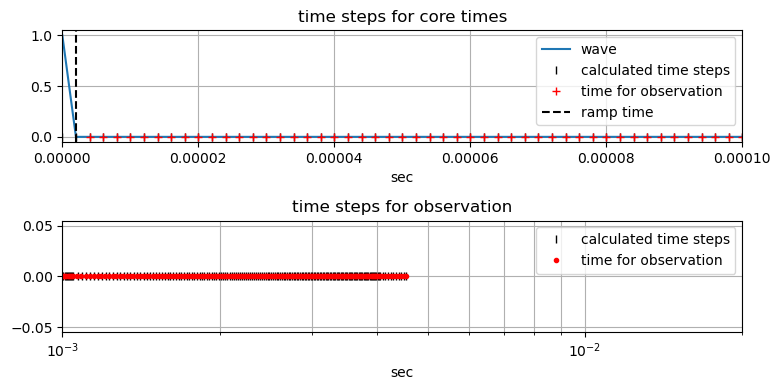

In [54]:
fig, ax = plt.subplots(2,1,figsize=(8,4))
ax[0].plot(prb_emip.times, [waveform.eval(t) for t in prb_emip.times],label='wave')
ax[0].plot(prb_emip.times, np.zeros_like(prb_emip.times), "|k",label='calculated time steps')
ax[0].plot(time_rec+rmp_time, np.zeros_like(time_rec), "+r",lw=3,label='time for observation')
ax[0].axvline(rmp_time, color='k', linestyle='--',label='ramp time')
ax[0].set_xlim(0,1e-4)#time_steps[0][0]*time_steps[0][1])
ax[0].set_title('time steps for core times')

ax[1].semilogx(prb_emip.times, np.zeros_like(prb_emip.times), "|k",label='calculated time steps')
ax[1].semilogx(time_rec, np.zeros_like(time_rec), "r.",lw=3,label='time for observation')
ax[1].set_title('time steps for observation')
ax[1].set_xlim(1e-3,2e-2)#time_steps[0][0]*time_steps[0][1])

for a in ax:
    a.grid(which='both')
    a.set_xlabel('sec')
    a.legend()
plt.tight_layout()
plt.show()

In [66]:
#sigmaInf=sigmaInfMap*sigma_target_vessel
sigmaInf=sigmaInfMap*sigma_target
fields_emip = prb_emip.fields(sigmaInf)

C:\Users\81805\anaconda3\envs\simpegEMIP\lib\site-packages\SimPEG\Props.py:400: UserWarning: Cannot add model as there are no active mappings, choose from: ['cMap', 'etaMap', 'rhoMap', 'sigmaInfMap', 'sigmaMap', 'tauMap']
  "', '".join(self._all_map_names)


In [67]:
# Get data from fields
data_emip = survey.dpred(sigmaInf, f=fields_emip)
dpred_emip =  data_emip* n_turns *tx_circumference
#dpred_emip_vessel =  data_emip* n_turns *tx_circumference

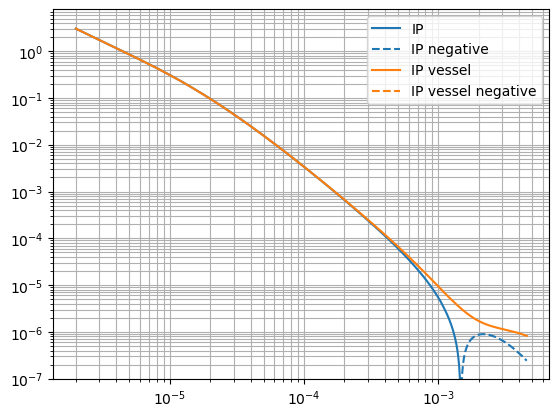

In [72]:
plt.loglog(time_rec, dpred_emip, 'C0', label="IP" )
plt.loglog(time_rec,-dpred_emip, 'C0',linestyle='--', label="IP negative")
plt.loglog(time_rec, dpred_emip_vessel, 'C1', label="IP vessel" )
plt.loglog(time_rec,-dpred_emip_vessel, 'C1',linestyle='--', label="IP vessel negative")
plt.legend()
plt.ylim(bottom=1e-7)
plt.grid(True, which='both')


In [71]:
# Adjust ramp time and export data in numpy format
np_save = np.zeros((3,len(time_rec)))
np_save[0,:] = time_rec
np_save[1,:] = dpred_emip_vessel
np_save[2,:] = dpred_emip

np.save("14_Pressure_vessel_LayerIP.npy", np_save)

In [62]:
np.save("14_fields_emip.npy", fields_emip[:,0,2:])
np.save("14_time_clc.npy", time_clc[1:]-rmp_time)